#REGINALDO GREGÓRIO DE SOUZA NETO
2252813

# Atividade 6 - Redução de Dimensionalidade para Classificação via PCA


Nesta atividade, usaremos um subset da base "Dota 2 Games Results", contendo dados de 9264 jogos. Os classificadores devem prever o time vencedor em cada partida. Cada jogo tem 116 características, incluindo ID do cluster, modo e tipo de jogo, e quais heróis foram escolhidos. Heróis usados por um time são marcados como 1 e pelo outro como -1. Cada time escolhe 5 heróis, então 10 colunas variam entre 1 e -1. A última coluna mostra o time vencedor. A maioria dos dados é zero, pois apenas 13 das 116 colunas são preenchidas.

### Visualizacao das caracteristicas

In [ ]:
import pandas as pd

# carregando o dataset
df = pd.read_csv('dota2DatasetTrain_header_01.csv')
df.head()

,cluster_id,game_mode,game_type,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,...,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111,hero_112,winning_team
0,156,2,2,0,0,0,-1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,204,2,2,0,0,0,0,1,0,0,...,0,0,0,0,0,-1,0,0,0,-1
2,227,8,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,153,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
4,153,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1


In [ ]:
# separando as caracteristicas do alvo
y = df['winning_team']
X = df.drop(['winning_team'], axis=1)

y.shape, X.shape

((9264,), (9264, 116))

Abaixo, é feito uso de PCA com apenas dois componentes principais, para permitir a visualização da base em apenas duas dimensões, no gráfico de dispersão

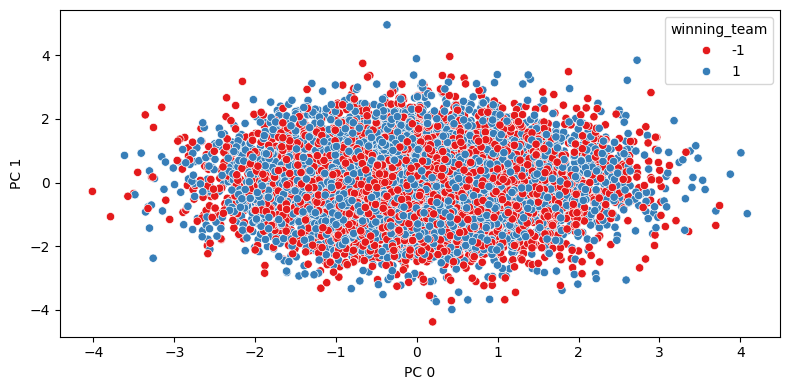

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# instancia o PCA, mantendo apenas os 2 primeiros componentes principais.
pca = PCA(n_components=2)

# realiza a normalização z-score
ss = StandardScaler()
ss.fit(X)
X_ss = ss.transform(X)

# calcula o PCA com os atributos normalizados
pca_ss = PCA(n_components=2)
pca_ss.fit(X_ss)
X_ss_pca = pca_ss.transform(X_ss)
X_ss_pca_df = pd.DataFrame(X_ss_pca, columns=['PC 0', 'PC 1'])

fig, ax = plt.subplots(figsize=(8,4))

sns.scatterplot(data=X_ss_pca_df, x='PC 0', y='PC 1', hue=y, palette='Set1', ax=ax)
fig.tight_layout()

Percebe-se que, com apenas dois componentes principais, os dados estão visualmente difíceis de separar, com bastante sobreposição entre uma classe e a outra.

A linha de código abaixo conta quantos valores nulos estão presentes no dataset. Como o resultado é zero, não é necessário fazer imputação de valores nulos.

In [ ]:
df.isnull().sum().sum()

0

### Avaliando os classificadores

O código mencionado configura uma série de classificadores para serem avaliados. A lista testes contém detalhes de cada classificador, como nome, instância, a necessidade de normalização dos dados, e o número de vias para validação cruzada em dois níveis. Para o classificador SVM, a validação cruzada ocorre em um único nível com otimização de parâmetros em um único conjunto de validação.

A função do_cv do arquivo utils.py gerencia a divisão dos dados em conjuntos de treino, teste e validação para a validação cruzada. Esta função retorna os f1-scores dos melhores ajustes de cada classificador, encontrados pela validação cruzada, e uma matriz de confusão acumulada durante os testes de validação cruzada externa. Estes resultados são armazenados nos dicionários resultados e confusao.

In [ ]:
import numpy as np

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

testes = [
    ("KNN", KNeighborsClassifier, True, 10, 5, {"n_neighbors" : range(1,30,2)}),
    ("SVM", SVC, True, 10, None, {
        "C" : np.logspace(0, 4, 5, base=10),
        "gamma" : list(np.logspace(-5, -2, 4, base=2)) + ["auto", "scale"]
        }
    ),
    ("RF", RandomForestClassifier, False, 10, 5, {"n_estimators" : [100, 200]}),
]

resultados = {}
confusao = {}

In [ ]:
from utils import do_cv, print_t_tests, imprimir_estatisticas

for nome, classificador, scale, cv_folds_ext, cv_folds_int, params in testes:
    print('Executando %s'% (nome))
    resultados[nome], confusao[nome] =  do_cv(classificador, X, y,
                                        cv_folds_ext, cv_folds_int,
                                        -1, scale, None,
                                        None, params)

Executando KNN


Folds avaliados: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


Executando SVM


Folds avaliados: 100%|██████████| 10/10 [04:32<00:00, 27.23s/it]


Executando RF


Folds avaliados: 100%|██████████| 10/10 [00:48<00:00,  4.82s/it]


In [ ]:
for teste in sorted(resultados):
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

       KNN - Resultados: 0.59 +- 0.02, min: 0.55, max: 0.63
        RF - Resultados: 0.61 +- 0.01, min: 0.59, max: 0.62
       SVM - Resultados: 0.69 +- 0.00, min: 0.69, max: 0.69


In [ ]:
print_t_tests(resultados, alpha=0.05)

                KNN          RF         SVM     
    KNN         1.00     0.05 (*<)   0.00 (*<)  
     RF      0.05 (*>)      1.00     0.00 (*<)  
    SVM      0.00 (*>)   0.00 (*>)      1.00    


Os resultados indicam uma diferença significativa no desempenho dos classificadores, com o SVM apresentando a performance mais alta. Apesar da proximidade nos resultados entre KNN e RandomForest, um teste T Student confirmou que o desempenho superior do RandomForest não foi atoa.

### Redução de dimensionalidade

Nesta etapa, a mesma lista de testes é utilizada, mas agora adicionando a redução da dimensionalidade dos dados através do PCA (Análise de Componentes Principais). O PCA busca simplificar a distribuição dos dados, reduzindo o número original de características ($k$) para um número menor de dimensões ($c$), com a condição de que $k>c$. Ele ordena os componentes principais, onde o primeiro componente representa a direção de maior variação nos dados, o segundo a segunda maior variação, e assim por diante. Ao definir $c=2$, obtemos os dois principais componentes que capturam a maior parte da variação nos dados. Um laço de repetição pode ser utilizado para testar diferentes valores de $c$ e avaliar o impacto na performance dos classificadores com dados de dimensões reduzidas.

In [ ]:
for n_components in [2, 8, 16, 32, 64]:
    print('n_components: %d' % (n_components))
    for nome, classificador, scale, cv_folds_ext, cv_folds_int, params in testes:
        nome = '%s_PCA_%d' % (nome, n_components)
        print('Executando %s'% (nome))
        resultados[nome], confusao[nome] = do_cv(classificador, X, y,
                                           cv_folds_ext, cv_folds_int,
                                           -1, scale, None,
                                           PCA(n_components=n_components),
                                           params)
    print("")

n_components: 2
Executando KNN_PCA_2


Folds avaliados: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Executando SVM_PCA_2


Folds avaliados: 100%|██████████| 10/10 [08:04<00:00, 48.49s/it]


Executando RF_PCA_2


Folds avaliados: 100%|██████████| 10/10 [00:49<00:00,  4.99s/it]



n_components: 8
Executando KNN_PCA_8


Folds avaliados: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


Executando SVM_PCA_8


Folds avaliados: 100%|██████████| 10/10 [41:45<00:00, 250.53s/it]


Executando RF_PCA_8


Folds avaliados: 100%|██████████| 10/10 [01:10<00:00,  7.09s/it]



n_components: 16
Executando KNN_PCA_16


Folds avaliados: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Executando SVM_PCA_16


Folds avaliados: 100%|██████████| 10/10 [06:24<00:00, 38.48s/it]


Executando RF_PCA_16


Folds avaliados: 100%|██████████| 10/10 [02:03<00:00, 12.34s/it]



n_components: 32
Executando KNN_PCA_32


Folds avaliados: 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


Executando SVM_PCA_32


Folds avaliados: 100%|██████████| 10/10 [02:43<00:00, 16.33s/it]


Executando RF_PCA_32


Folds avaliados: 100%|██████████| 10/10 [02:32<00:00, 15.28s/it]



n_components: 64
Executando KNN_PCA_64


Folds avaliados: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Executando SVM_PCA_64


Folds avaliados: 100%|██████████| 10/10 [02:48<00:00, 16.88s/it]


Executando RF_PCA_64


Folds avaliados: 100%|██████████| 10/10 [03:50<00:00, 23.07s/it]

Antes de olhar os resultados, é interessante observar o tempo de execução do SVM. Com 8 componentes principais, ele demorou quase 10 vezes mais para executar do que com o número de atributos originais.

Isso pode ser explicado pelo funcionamento do SVM, que é um tipo de modelo de aprendizado de máquina que procura uma linha (ou hiperplano) para separar diferentes classes de dados.

Com menos atributos, o SVM pode precisar de mais ajustes nos seus parâmetros para funcionar bem, pois ao diminuir a dimensionalidade dos dados, eles podem se tornar menos linearmente separáveis, então, torna-se necessário o uso do *kernel trick* para transformar os dados para um espaço de maior dimensão, onde eles são linearmente separáveis. Ou seja, pela natureza do SVM, é provável que, ao menos com oito componentes principais, o classificador precisou aumentar consideravelmente a dimensão dos dados novamente para conseguir separar os dados, desfazendo o trabalho de redução do PCA.

In [ ]:
resultados_knn = {}
resultados_rf = {}
resultados_svm = {}

for teste in resultados:
    if teste.startswith("KNN"):
        resultados_knn[teste] = resultados[teste]
    elif teste.startswith("RF"):
        resultados_rf[teste] = resultados[teste]
    elif teste.startswith("SVM"):
        resultados_svm[teste] = resultados[teste]

In [ ]:
for teste in sorted(resultados_knn):
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados_knn[teste])

print("\n")
print_t_tests(resultados_knn, alpha=0.05)


       KNN - Resultados: 0.59 +- 0.02, min: 0.55, max: 0.63
KNN_PCA_16 - Resultados: 0.57 +- 0.01, min: 0.55, max: 0.59
 KNN_PCA_2 - Resultados: 0.56 +- 0.02, min: 0.54, max: 0.59
KNN_PCA_32 - Resultados: 0.58 +- 0.02, min: 0.56, max: 0.61
KNN_PCA_64 - Resultados: 0.58 +- 0.01, min: 0.56, max: 0.61
 KNN_PCA_8 - Resultados: 0.57 +- 0.02, min: 0.54, max: 0.60


                KNN      KNN_PCA_16  KNN_PCA_2   KNN_PCA_32  KNN_PCA_64  KNN_PCA_8  
    KNN         1.00     0.02 (*>)   0.00 (*>)      0.23        0.40     0.01 (*>)  
 KNN_PCA_16  0.02 (*<)      1.00        0.18        0.29        0.06        0.31    
 KNN_PCA_2   0.00 (*<)      0.18        1.00     0.05 (*<)   0.01 (*<)      0.76    
 KNN_PCA_32     0.23        0.29     0.05 (*>)      1.00        0.59        0.08    
 KNN_PCA_64     0.40        0.06     0.01 (*>)      0.59        1.00     0.01 (*>)  
 KNN_PCA_8   0.01 (*<)      0.31        0.76        0.08     0.01 (*<)      1.00    


Observando os resultados do teste-t, observa-se que o KNN obteve resultado equivalente, ao menos para essa base de dados, com 32 e 64 componentes principais. Isso indica que, apesar de não ter melhorado o desempenho do classificador, diminuir a dimensionalidade pode ser uma boa pedida para diminuir o custo computacional do modelo.

In [ ]:
for teste in resultados_svm:
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados_svm[teste])

print("\n")
print_t_tests(resultados_svm, alpha=0.05)

       SVM - Resultados: 0.69 +- 0.00, min: 0.69, max: 0.69
 SVM_PCA_2 - Resultados: 0.69 +- 0.00, min: 0.69, max: 0.69
 SVM_PCA_8 - Resultados: 0.67 +- 0.01, min: 0.65, max: 0.69
SVM_PCA_16 - Resultados: 0.63 +- 0.01, min: 0.61, max: 0.65
SVM_PCA_32 - Resultados: 0.69 +- 0.00, min: 0.69, max: 0.69
SVM_PCA_64 - Resultados: 0.69 +- 0.00, min: 0.69, max: 0.69


                SVM      SVM_PCA_16  SVM_PCA_2   SVM_PCA_32  SVM_PCA_64  SVM_PCA_8  
    SVM         1.00     0.00 (*>)      0.36        0.30        0.61     0.00 (*>)  
 SVM_PCA_16  0.00 (*<)      1.00     0.00 (*<)   0.00 (*<)   0.00 (*<)   0.00 (*<)  
 SVM_PCA_2      0.36     0.00 (*>)      1.00        0.14        0.62     0.00 (*>)  
 SVM_PCA_32     0.30     0.00 (*>)      0.14        1.00        0.19     0.00 (*>)  
 SVM_PCA_64     0.61     0.00 (*>)      0.62        0.19        1.00     0.00 (*>)  
 SVM_PCA_8   0.00 (*<)   0.00 (*>)   0.00 (*<)   0.00 (*<)   0.00 (*<)      1.00    


O SVM teve desempenho equivalente com a base original com 2, 32 e 64 componentes, mas como comentado anteriormente, pode ser que diminuir a dimensionalidade dos dados da SVM aumente ainda mais o custo da execução do modelo, o que pode atrapalhar mais do que ajudar. Apesar disso, o tempo de execução do algoritmo com 32 e 64 componentes principais foi menor do que com a base original, o que pode indicar que diminunir a dimensionalidade não é necessáriamente ruim, desde que a diminuição não seja brusca de mais.

In [ ]:
for teste in resultados_rf:
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados_rf[teste])

print("\n")
print_t_tests(resultados_rf, alpha=0.05)

        RF - Resultados: 0.61 +- 0.01, min: 0.59, max: 0.62
  RF_PCA_2 - Resultados: 0.53 +- 0.02, min: 0.51, max: 0.55
  RF_PCA_8 - Resultados: 0.57 +- 0.01, min: 0.55, max: 0.59
 RF_PCA_16 - Resultados: 0.58 +- 0.01, min: 0.56, max: 0.60
 RF_PCA_32 - Resultados: 0.60 +- 0.01, min: 0.59, max: 0.62
 RF_PCA_64 - Resultados: 0.61 +- 0.01, min: 0.59, max: 0.63


                 RF      RF_PCA_16    RF_PCA_2   RF_PCA_32   RF_PCA_64    RF_PCA_8  
     RF         1.00     0.00 (*>)   0.00 (*>)      0.25        0.18     0.00 (*>)  
 RF_PCA_16   0.00 (*<)      1.00     0.00 (*>)   0.00 (*<)   0.00 (*<)      0.05    
  RF_PCA_2   0.00 (*<)   0.00 (*<)      1.00     0.00 (*<)   0.00 (*<)   0.00 (*<)  
 RF_PCA_32      0.25     0.00 (*>)   0.00 (*>)      1.00     0.02 (*<)   0.00 (*>)  
 RF_PCA_64      0.18     0.00 (*>)   0.00 (*>)   0.02 (*>)      1.00     0.00 (*>)  
  RF_PCA_8   0.00 (*<)      0.05     0.00 (*>)   0.00 (*<)   0.00 (*<)      1.00    


O Random Forest com redução de dimensionalidade teve desempenho equivalente ao original com 32 e 64 componentes.

### Conclusões


O SVM, sem PCA, teve um f1-score de 0.69, o mais alto e consistente entre os métodos. Mesmo com PCA de 32 e 64 componentes, o SVM manteve esse score, indicando que a redução de dimensionalidade não afetou seu desempenho. Já o Random Forest com 2 componentes PCA caiu para um f1-score de 0.53, mostrando que a redução drástica de dimensões prejudicou seu desempenho. O SVM com 16 componentes PCA também teve desempenho reduzido (0.63), sugerindo que essa quantidade de componentes não é ideal. Em resumo, o SVM se mostrou robusto com diferentes configurações de PCA, enquanto o Random Forest foi mais sensível à redução de dimensionalidade.
O KNN apresentou um desempenho levemente inferior em todas as configurações com PCA, indicando que a redução de dimensionalidade e a consequente perda de informação não foram favoráveis para esse algoritmo.